In [ ]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw

from tqdm.notebook import tqdm

from time import process_time 

import multiprocessing  
from multiprocessing import Pool

%matplotlib inline      

In [ ]:
# Download polygons
!wget --quiet https://tong-zhao.github.io/assets/data/box.xy
!wget --quiet https://tong-zhao.github.io/assets/data/stacked_box.xy
!wget --quiet https://tong-zhao.github.io/assets/data/star.xy

In [ ]:
coordonne_s = np.array([[-1,2],[1,2],[0.5,0],[1,-2],[-1,-2],[-0.5,0]])
f_s = open("sablier.xy","w")
np.savetxt(f_s, coordonne_s, delimiter = ' ')
f_s.close()

!cat sablier.xy

-1.000000000000000000e+00 2.000000000000000000e+00
1.000000000000000000e+00 2.000000000000000000e+00
5.000000000000000000e-01 0.000000000000000000e+00
1.000000000000000000e+00 -2.000000000000000000e+00
-1.000000000000000000e+00 -2.000000000000000000e+00
-5.000000000000000000e-01 0.000000000000000000e+00


In [ ]:
coordonne_e = np.array([[-2,0],[0.5,3],[0.5,0],[2,0],[-0.5,-3],[-0.5,0]])
f_e = open("eclair.xy","w")
np.savetxt(f_e, coordonne_e, delimiter = ' ')
f_e.close()

!cat eclair.xy

-2.000000000000000000e+00 0.000000000000000000e+00
5.000000000000000000e-01 3.000000000000000000e+00
5.000000000000000000e-01 0.000000000000000000e+00
2.000000000000000000e+00 0.000000000000000000e+00
-5.000000000000000000e-01 -3.000000000000000000e+00
-5.000000000000000000e-01 0.000000000000000000e+00


In [ ]:
coordonne_sapin = np.array([[-3,0],[-1.5,-1],[-2.5,-1],[-1,-2],[-1.5,-2],[0,-3],[1.5,-2],[1,-2],[2.5,-1],[1.5,-1],[3,0]])
f_sap = open("sapin.xy","w")
np.savetxt(f_sap, coordonne_sapin, delimiter = ' ')
f_sap.close()

!cat sapin.xy

-3.000000000000000000e+00 0.000000000000000000e+00
-1.500000000000000000e+00 -1.000000000000000000e+00
-2.500000000000000000e+00 -1.000000000000000000e+00
-1.000000000000000000e+00 -2.000000000000000000e+00
-1.500000000000000000e+00 -2.000000000000000000e+00
0.000000000000000000e+00 -3.000000000000000000e+00
1.500000000000000000e+00 -2.000000000000000000e+00
1.000000000000000000e+00 -2.000000000000000000e+00
2.500000000000000000e+00 -1.000000000000000000e+00
1.500000000000000000e+00 -1.000000000000000000e+00
3.000000000000000000e+00 0.000000000000000000e+00


In [ ]:
img_size = 256
epsilon = 1e-2

## I/O Functions

In [ ]:
def read_xy(file):
    
    with open(file, "r") as fp:
        fp_line = fp.read().split("\n")[:-1]
    
    points = np.array([line.split() for line in fp_line]).astype(float)
    # center all points
    centroid = (points.mean(0)).reshape((1, -1))
    points = points - centroid
    # normalize shape length
    length = (points.max(0) - points.min(0)).max() / (img_size * 0.7)
    normalized_pts = (points / length).astype(int) + img_size // 2
    
    return normalized_pts

## Visualization Functions 

In [ ]:
def plot_polygon(poly_verts, size = 8):
    
    img = Image.new('L', (img_size, img_size)) #image en noir et blanc  (un pixel sur 8bit)
    ImageDraw.Draw(img).polygon(points.reshape((-1, )).tolist(), outline = 'blue', fill = 'white')
    
    plt.figure(figsize = (size, size))
    plt.imshow(img, cmap='gray')
    plt.plot()

In [ ]:
def plot_signed_distance_field(dist_map, poly_verts, size = 8):
    
    pos_dist_map = dist_map - dist_map.min()
    img_dist = Image.fromarray(np.uint8(pos_dist_map / pos_dist_map.max() * 255) , 'L')
    ImageDraw.Draw(img_dist).polygon(poly_verts.reshape((-1, )).tolist(), outline = 'blue', fill = None)

    plt.figure(figsize = (size, size))
    plt.imshow(img_dist)
    plt.plot()

In [ ]:
def plot_offset(offset, size = 8):
    
    img_dist = Image.fromarray(np.uint8(offset * 255) , 'L')

    plt.figure(figsize = (size, size))
    plt.imshow(img_dist, cmap = 'gray')
    plt.plot()

## Geometric Functions

### Intersection between segments

In [ ]:
def ccw(A, B, C):
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

# Return true if line segments AB and CD intersect
def intersect_point_segment(A, B, C, D):
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

In [ ]:
def ccw_matrix(A, B, C):
    
    return (C[:, 1] - A[:, 1]) * (B[:, 0] - A[:, 0]) > (B[:, 1] - A[:, 1]) * (C[:, 0] - A[:, 0])

def intersect_matrix_segment(A, mat_b, C, D): # only B is matrix
    
    num = mat_b.shape[0]
    mat_a = np.tile(A.reshape((1, -1)), (num, 1))
    mat_c = np.tile(C.reshape((1, -1)), (num, 1))
    mat_d = np.tile(D.reshape((1, -1)), (num, 1))
    
    return np.logical_and(np.logical_xor(ccw_matrix(mat_a, mat_c, mat_d), ccw_matrix(mat_b, mat_c, mat_d)), 
                          np.logical_xor(ccw_matrix(mat_a, mat_b, mat_c), ccw_matrix(mat_a, mat_b, mat_d)))
    
    #rend une matrice (256**2,2) 

### Distance Functions

In [ ]:
def distance_from_point_to_segment(query, seg_a, seg_b):
    
    vec_qa = query - seg_a
    vec_ba = seg_b - seg_a
    
    dot_prod = (vec_qa * vec_ba).sum()
    len_ba = (vec_ba * vec_ba).sum()
    
    lambd = dot_prod / len_ba
    
    if lambd <= 0:
        return np.linalg.norm(query - seg_a)
    elif lambd >= 1:
        return np.linalg.norm(query - seg_b)
    else:
        proj = seg_a + lambd * vec_ba
        return np.linalg.norm(query - proj)

In [ ]:
def distance_from_matrix_to_segment(points, seg_a, seg_b):
    
    mat_qa = points - seg_a
    vec_ba = (seg_b - seg_a).reshape((1, -1))
    
    dot_prod = (mat_qa * vec_ba).sum(1)
    len_ba = (vec_ba * vec_ba).sum()
    
    lambd = dot_prod / len_ba
    dists = np.zeros_like(lambd)
    
    indices_0 = (lambd <= 0)
    indices_1 = (lambd >= 1)
    indices_2 = np.logical_and(np.logical_not(indices_0), np.logical_not(indices_1))
    
    dists[indices_0] = np.linalg.norm(points[indices_0] - seg_a, axis = 1)
    dists[indices_1] = np.linalg.norm(points[indices_1] - seg_b, axis = 1)
    dists[indices_2] = np.linalg.norm(points[indices_2] - seg_a - lambd[indices_2].reshape((-1, 1)) * vec_ba, axis = 1)
    
    return dists.reshape((-1, 1))

### Distance Oracle

In [ ]:
class DistanceQuery:
    
    def __init__(self):
        self.poly_verts = []
        self.size = 0
        
    def is_init(self):
        return True if self.size > 0 else False
        
    def update(self, poly_verts):
        self.poly_verts = poly_verts
        self.size = poly_verts.shape[0]
        
    def distance(self, query):
        min_dist = 1e10
        count = 0
        for i in range(self.size):
            dist = distance_from_point_to_segment(query, self.poly_verts[i], self.poly_verts[(i + 1) % self.size])
            min_dist = min(dist, min_dist)
            if intersect_point_segment([0, 0], query, self.poly_verts[i], self.poly_verts[(i + 1) % self.size]):
                count += 1
                
        if count % 2 == 1:
            min_dist = -min_dist
        
        return min_dist 
    
    def distance_matrix(self, query_mat):
        min_dists = []
        min_count = np.zeros((query_mat.shape[0], 1))
        
        for i in range(self.size):
            dist = distance_from_matrix_to_segment(query_mat, 
                                                   self.poly_verts[i], 
                                                   self.poly_verts[(i + 1) % self.size])
            min_dists.append(dist)
            
            count = intersect_matrix_segment(np.array([0, 0]), query_mat, 
                                             self.poly_verts[i], 
                                             self.poly_verts[(i + 1) % self.size])
            min_count = min_count + count.reshape((-1, 1))
            
        min_dists = np.hstack(min_dists).min(1)
        flag_neg = np.squeeze(min_count % 2 == 1)
        min_dists[flag_neg] = -min_dists[flag_neg]
        
        return min_dists

# Passages à zéro sur rayon  



> Le but de cette partie est d'avoir une fonction qui ,pour un rayon donné,  nous renvoit les deux points consécutifs correspondant aux passage par zéro  ,donc quand on croise S', les plus proches du point de requête.



> Ces deux points étant les meilleurs points ,pour un rayon donné, entre lesquels on va faire la bissection\newton\dichotomie



In [ ]:
def evaluate_f(query, o1):
    """
    retourne la distance signée entre le point de requête, query, et S' (premier offset)
    """
    return dist_oracle.distance(query) - o1

In [ ]:
def evaluate_fmat(mat_query, o1):
    """
    retourne une liste des distances signées entre la matrice de points de requête, mat_query, et S' (premier offset)
    """
    return dist_oracle.distance_matrix(mat_query) - o1

In [ ]:
def initialize_n_point(query, rayon, nb_point_init):
    """
    Initialise nb_point_init points le long du rayon, rayon, pour le point de requête, query.
    Le pas entre ces points est : longueur_de_la_diagonale/nb_point_init

    Retourne: une matrice nb_point_init*2 ; volontairement ordonnée telle que son premier élément est le point initial le plus à gauche (sur le graphe de plt)
    Ce détail est important, par la suite, lors des recherches des passages à zéro. 
    """

    pas = img_size * np.sqrt(2) / nb_point_init  #longueur de la diagonale divisée par nb_point_init
    candidates = np.arange(-nb_point_init, nb_point_init).reshape((-1, 1)) * pas * rayon.reshape((1, -1)) + query.reshape((1, -1))
    mask = np.all(np.bitwise_and(candidates >= 0, candidates < img_size), 1)
    res = candidates[mask]

    return res



> Etant donné un rayon, un point de requête, cette fonction retourne les paires de points CONSECUTIFS qui correspondent à un changement de signe pour la fonction distance signée à S'



> Parmi nos n points initiaux, on commence sur celui qui est le plus à gauche. On parcourt chaque paire de point consécutif le long du rayon et si une paire correspond à un changement de signe on la stocke 



> Si aucune paire de point candidate à un changement de signe n'a été trouvé on retourne None, sinon on retourne la matrice nx2 avec n le nombre de couples trouvée






In [ ]:
def find_zero_on_r(query, rayon, nb_point_init):
    """
    Parmi les points initiaux d'un rayon, on cherche ceux les paires de points consécutifs qui chevauchent S'

    Retourne une matrice contenant tous les couples de points consécutifs candidats à un passage à zéro
    """

    #on inititalise les points (on rappelle que le premier élément dans points est le point initial le plus à gauche sur le rayon)
    points = initialize_n_point(query, rayon, nb_point_init)

    funcs = evaluate_fmat(points, o1)
    
    indices_zeros = np.where((np.diff(np.sign(funcs)) != 0) == 1)[0]
    #on a tous les indices du point gauche des paires de points candidats à un passage à zéro

    if len(indices_zeros) == 0:
        # print("Le rayon",rayon,"passant par",query,"n'intersecte jamais la surface S'")
        return None


    return np.hstack((points[indices_zeros], points[indices_zeros + 1])).reshape((-1, 2))
    #(points[i],points[i+1]) est le couple candidat à un passage à zéro
    #on retourne la matrice contenant tous les couples de points candidats à un passage à zéro



> Ici on a des couples de points candidats à un passage à zéros sur un rayon, pour un point de requête donné, on veut savoir le couple de points le plus proche de ce point de requête



---


> Pour chaque point, on calcule leur distance à q et on prend le minimum parmi ces distances.

> Ensuite, on trouve le point le plus proche du point précédemment trouvé. 

> Ainsi, avec les deux points précédemments trouvés, on a la paire de points, la plus proche du point de requête , associée à une intersection avec S'

> On retourne un matrice 2x2 qui correspond à cette paire de points (deux points les plus proches de q le long d'un rayon qui chevauchent S')







In [ ]:
def find_nearest_zero_from_q(query, points):
    """
    points : matrice qui contient toutes les paires de points candidats (sera le résultat retourné par find_zero_on_r(query,rayon,nb_point_init))

    Retourne une matrice 2x2 qui correspond à le paire de points; tq ce sont les deux points consécutifs les plus proches de q le long du rayon qui chevauchent S'.
    """
    #si précédemment aucun couple candidat n'a été trouvé
    if type(points) == type(None):
        return None

    if len(points) == 2:
        return points

    distances = np.linalg.norm(points - query.reshape((1, -1)), axis = 1)
    indice= np.argsort(distances)[0]

    # on retourne la matrice 2*2 constituée des deux meilleurs points entre lesquels on va rechercher le zéro 
    if indice % 2 == 0:
        return points[indice : indice + 2]
    else:
        return points[indice - 1 : indice + 1]

In [ ]:
def plot_fonction_distance(query, rayon, nb_point_init, o1):
    """
    Trace la fonction distance signée à S' sur un graphe (on obtient donc un nuage de point)
    L'axe des x correspond au rayon ; se déplacer selon l'axe x revient à se déplacer sur le rayon
    Les passages à zéro de la fonction correspondent donc aux intersections entre le rayon et S'
    """

    points = initialize_n_point(query, rayon, nb_point_init)
    funcs = evaluate_fmat(points, o1)

    #nuage de point représentant la fonction distance signée à S', où l'abscisse représente le rayon
    plt.scatter(points[:, 0], points[:, 1], c = funcs)
    plt.scatter(query[0], query[1], c = 'r')
    plt.grid()

    tt = "Fonction distance signée à S'. Pour q:", query, "et rayon:", rayon
    plt.title(tt)

# Recherche de zéros (passage sur S') le long d'un rayon


*   Bissection récursive
*   Newton
*   Bissection Linéaire



> Etant donné une paire de points qui sont les plus proches points de q sur le rayon r chevauchant S', on effectue une dichotomie entre ces deux points le long du rayon pour trouver le point sur S' le long du rayon.



> Recherche de zéro de fonction le long d'un rayon par dichotomie





In [ ]:
def bissection_rec(points, rayon):
  
    if type(points) == type(None):
        return None

    a, b = points[0], points[1]
    fa = evaluate_f(a, o1)
    fb = evaluate_f(b, o1)

    while np.abs(fa) > epsilon and np.abs(fb) > epsilon and np.linalg.norm(a - b) > epsilon:  #ou supérieur à un epsilon très faible
        mil = (a + b) / 2
        fmil = evaluate_f(mil, o1)

        if (fa * fmil) <= 0:
            b = mil
            fb = fmil
        else:
            a = mil
            fa = fmil

    #on retourne le point qui est sur S'
    return a if np.abs(fa) < epsilon else b



> Approximation de la dérivée première de la fonction signée à S' d'un point sur le rayon telle que on prend ses deux voisins sur le rayon divisé par 2*pas 


> Schéma décentrée: $\frac{f(x_{n+1})-f(x_{n-1})}{2h}$
avec $x_{n+1}$ et $x_{n-1}$ les deux voisins de $x_n$ sur le rayon et $h$ l'écart entre deux points sur le rayon




In [ ]:
def df(p, rayon):
    r = rayon / 100
    h = np.linalg.norm(r)
    return (evaluate_f((p + r), o1) - evaluate_f((p - r), o1)) / (2 * h)



> Etant donné le couple de point le plus proche de q sur le rayon r chevauchant S', on va choisir le plus proche de S' parmi ce couple de points. Et effectuer l'algo de newton à partir de ce point pour trouver le point sur le rayon r qui est sur S'



> Recherche de zéro de fonction le long d'un rayon par l'algo de newton
$x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}$




In [ ]:
def newton(points,rayon):  #version méthode des sécantes car dérivée approchée par différences finies

    if type(points) == type(None):
        return None

    #on choisit le point le plus proche de S’ sur lequel on va commencer l’algo
    x = points[0]
    direction = rayon / np.linalg.norm(rayon)
    if abs(evaluate_f(points[0],o1)) > abs(evaluate_f(points[1],o1)):
        x = points[1]

    fx = evaluate_f(x, o1)

    while abs(fx) > epsilon:

        dfx = df(x, rayon)
        if abs(dfx) < 0.5:
            # print("Invalid gradient!")
            return x
            
        x = x - ((fx / dfx) * direction) #formule de récurrence de l’algo de newton
        fx = evaluate_f(x, o1)
    return x

In [ ]:
def bissection_rec_lineaire(points, rayon):
  
    if type(points) == type(None):
        return None

    a, b = points[0], points[1]
    fa = evaluate_f(a, o1)
    fb = evaluate_f(b, o1)

    while np.abs(fa) > epsilon and np.abs(fb) > epsilon and np.linalg.norm(a - b) > epsilon:  #ou supérieur à un epsilon très faible
        #on cherche le point p sur le seg [a,b] d'où p=lambda*a+(1-lambda)*b
        #tel que f(p)=0 donc lambda est solution de f(p)=0=lambda*f(a)+(1-lambda)*f(b)
        lbda = fb/(fb-fa)

        p = lbda*a + (1-lbda)*b

        fp = evaluate_f(p, o1)

        if (fa * fp) <= 0:
            b = p
            fb = fp
        else:
            a = p
            fa = fp

    #on retourne le point qui est sur S'
    return a if np.abs(fa) < epsilon else b



---



# Recherche, parmi plusieurs rayons, du point associé à la distance minimale entre query et le point sur S'

 

*   A ce stade, étant donné un point de requête q, on sait associer à chaque rayon le point sur S' le plus proche de q étant sur le rayon. Donc, pour chaque rayon est associé un point candidat.
*   Maintenant, il reste à trouver le meilleur rayon ; c'est-à-dire, pour un point q donné, le rayon qui minimise la distance entre q et le point candidat qui lui est associé


*   Une première idée pour trouver ce meilleur rayon est une **bissection récursive sur les angles**










> Cette fonction génére $n$ rayons uniformément; cest-à-dire tous les $\frac{2\pi}{n}$.



In [ ]:
def init_rayon(nb_rayon):
    """
    Génére nb_rayon rayons uniformément 

    Retourne une matrice nb_rayon*2 qui contient les pentes de chaque rayon créé
    """
    #le pas de l'angle entre chaque rayon
    step = np.arange(0, np.pi, np.pi / nb_rayon)
    res = np.vstack((np.cos(step), np.sin(step)))

    return res.T

In [ ]:
def plot_rayon_around_point(nb_rayon, query, nb_point_init):
    """
    Dessine les rayons initiaux autour d'un point
    """
    plot_signed_distance_field(dist_map,points)
    t=init_rayon(nb_rayon)
    for i in range(len(t)):
        point_initiaux = initialize_n_point(query, t[i], nb_point_init)
        plt.scatter(point_initiaux[:,0], point_initiaux[:,1])

In [ ]:
def zero_sur_rayon(query, rayon, methode, nb_point_init):
    """
    methode : procédé pour trouver point correspondant au zéro sur un rayon (bissection, newton...)
    retourne point_min  où point_min est le point sur S' trouvé par methode
    """

    meilleur_point = find_nearest_zero_from_q(query, find_zero_on_r(query, rayon, nb_point_init))

    if type(meilleur_point) == type(None):
        return None

    # Au meilleur point on applique la recherche de zéro
    point_offset = methode(meilleur_point, rayon)

    #étant donnés un point de requête , un rayon et une méthode de recherche de zéro
    #on renvoie le point sur S' et le rayon
    #point_min
    return point_offset



---
Pour un point de requête donné , on sait associer un rayon avec le point sur S' le plus proche du point de requête ; à travers une méthode de recherche par zéro.

Pour un point de requête donné , on veut la liste de tous ces rayons associés au point candidat sur S'.
 
Pour pouvoir ensuite faire une dichotomie angulaire parmi tous ces rayons, afin de trouver le meilleur rayon en terme de distance à q...

In [ ]:
def zeros_pour_q(query, methode, nb_rayon, nb_point_init):
    """
    Pour un point de requête query, on récupère pour chacun de ses rayons associés, les points sur l'offset et le rayon 

    Retourne deux np.array: rayons [n, 2] et zero points [n, 2]
    """

    zero_rays, zero_points = [], []

    #on récupère les rayons (leurs pentes)
    rays = init_rayon(nb_rayon)

    #pour chaque rayon
    for i in range(len(rays)):
        zeros = zero_sur_rayon(query, rays[i], methode, nb_point_init)
        if type(zeros) != type(None):
            #on récupère le point_min qui lui est associé ; s'il existe
            zero_rays.append(rays[i])
            zero_points.append(zeros)

    # Retourne deux np.array: rayons [n, 2] et zero points [n, 2]
    return np.array(zero_rays), np.array(zero_points)



---
Pour commencer la bissection angulaire, il faut trouver entre quels rayons on effectue cette bissection.

On choisit le rayon minimal c'est-à-dire le rayon qui est associé au point sur S' le plus proche de q. 

On choisit ses deux voisins. 

On fera deux bissections angulaires entre le rayon minimal et son voisin de gauche ; et entre le rayon minimal et son voisin de droite.

On garde le meilleur résultat entre les deux bissections.

In [ ]:
def find_min_and_2neig_among_rays(query, rayons, zero_points):
    """
    data : deux np.array: rayons [n, 2] et zero points [n, 2]

    Retourne : la liste des rayons (avec leur point_min) entre lesquels on va faire la dichotomie angulaire

    """

    dists = np.linalg.norm(zero_points - query.reshape((1, -1)), axis = 1)
    ind = np.argsort(dists)[0]

    num_rayons = len(rayons)
    final_inds = [(ind - 1) % num_rayons, ind, (ind + 1) % num_rayons]

    # la liste des rayons (avec leur point_min) entre lesquels on va faire la dichotomie angulaire
    return rayons[final_inds], zero_points[final_inds]

Maintenant que nous savons les deux paires de rayons sur lesquels commencer la bissection angulaire, nous implémentons ce procédé.

In [ ]:
def bissection_angle(rayons, points, query, methode, nb_point_init):

    a, b = rayons[0], rayons[1]
    pa, pb = points[0], points[1]

    while np.linalg.norm(a - b) > epsilon:  #si la pente des deux rayons est quasi pareil on arrete
    # print("a=",a[0],"f(a)=",np.linalg.norm(a[1]-query),"\n b=",b[0],"f(b)=",np.linalg.norm(b[1]-query))
    # print(" lllll ",np.linalg.norm(a[0]-b[0]))

        mil = (a + b) / 2

        if np.linalg.norm(pa - query) < np.linalg.norm(pb - query):
            b = mil
            pb = methode(find_nearest_zero_from_q(query, find_zero_on_r(query, b, nb_point_init)), b)
        else:
            a = mil
            pa = methode(find_nearest_zero_from_q(query, find_zero_on_r(query, a, nb_point_init)), a)
            
        if type(pa) == type(None):
            return [b, pb]
    
        if type(pb) == type(None):
            return [a, pa]

    return [a, pa] if np.linalg.norm(pa - query) < np.linalg.norm(pb - query) else [b, pb]

On choisit le meilleur résultat entre les deux bissections effectuées
(celle faite avec le voisin de gauche et celle faite avec le voisin de droite)

In [ ]:
def choose_best_bissec(res1, res2, query):
    #res1 et res2 sont des listes de tableaux   [ rayon , point_min ]
    #res1 et res2 sont les resultats renvoyés par les deux bissections angulaires faites ci-dessus
    return res1 if np.linalg.norm(res1[1] - query) < np.linalg.norm(res2[1] - query) else res2



---



Version hybride : prise en compte des points concaves 

In [ ]:
def find_concave_point(points):
  #points doit définir les sommets du polygone dans un ordre CLOCKWISE
  
  #matrice des vecteurs [vertex i , vertex i-1] 
  vec_ab = np.roll(points, 1, axis = 0) - points
  # tournés de -pi/2 ; rotate -90
  vec_ab = vec_ab[:,[1, 0]]
  vec_ab[:, 0] = -vec_ab[:, 0]
  #matrice des vecteurs [vertex i , vertex i+1]
  vec_ac = np.roll(points, -1, axis = 0) - points
  # cross product
  prod = (vec_ab * vec_ac).sum(1)
  
  return np.where(prod < 0)[0] 


In [ ]:
def get_points_concave_on_first_offset(points,indice,o1):

  ind_left=(indice - 1) % len(points)
  ind_rigth=(indice + 1) % len(points)

  vects_i_ib= (points[ind_left]-points[indice])
  vects_i_ib=vects_i_ib/np.linalg.norm(vects_i_ib,axis=1).reshape((-1,1))

  vects_i_ia= (points[ind_rigth]-points[indice])
  vects_i_ia=vects_i_ia/np.linalg.norm(vects_i_ia,axis=1).reshape((-1,1))
  
  vects_bissectrice=( vects_i_ia + vects_i_ib ) / 2
  vects_bissectrice=vects_bissectrice/np.linalg.norm(vects_bissectrice,axis=1).reshape((-1,1))

  angles=(vects_i_ia*vects_i_ib).sum(1)

  distances = o1/np.sqrt( (1-angles) / 2 )
  distances = distances.reshape((-1,1))

  return points[indice] + distances*vects_bissectrice

In [ ]:
def find_nearest_concave_from_q(points_concaves,query):
  if len(points_concaves)==0:
    return 1e15

  distances=np.linalg.norm( points_concaves - query.reshape((1,-1)) , axis=1)

  return np.min(distances)

In [ ]:
def oracle_double_offset(query, o2, methode, nb_point_init, nb_rayon,points_concaves):
    """
    Retourne la distance signée entre query et S''
    """

    rayons, zero_points = zeros_pour_q(query, methode, nb_rayon, nb_point_init) 
    final_rayons, final_zeros = find_min_and_2neig_among_rays(query, rayons, zero_points)

    left  = bissection_angle(final_rayons[:2], final_zeros[:2], query, methode, nb_point_init) #renvoie [ rayon , point_min ] 
    right = bissection_angle(final_rayons[1:], final_zeros[1:], query, methode, nb_point_init) #renvoie [ rayon , point_min ]

    best = choose_best_bissec(left, right, query) #renvoie [ rayon , point_min ]

    dist = np.linalg.norm(best[1] - query)
    dist_concave=find_nearest_concave_from_q(points_concaves,query)

    # on choisit la distance minimale entre celle renvoyée par la recherche bissec/newton ET celle entre le point concave le plus proche
    dist=min(dist,dist_concave)

    if evaluate_f(query, o1) < 0:
        dist = -dist

    return dist - o2

In [ ]:
def oracle_double_offset_wrapper(ind_coord):

    global mat, o2, methode , points_concaves

    dist = oracle_double_offset(mat[ind_coord], o2, methode, 20, 20, points_concaves)
    return dist

# Main Function

Read polygon...

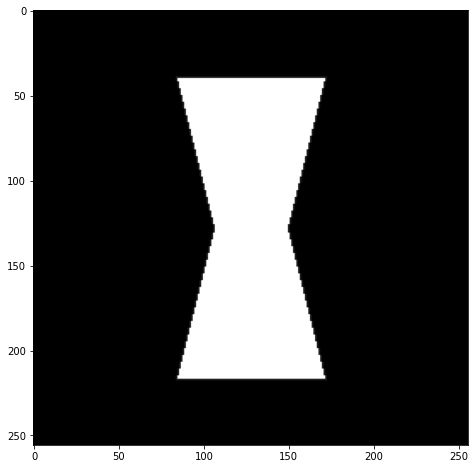

In [ ]:
# sablier et eclair
points = read_xy("sablier.xy")
plot_polygon(points)

Compute signed distance function...

In [ ]:
dist_oracle = DistanceQuery()
dist_oracle.update(points)

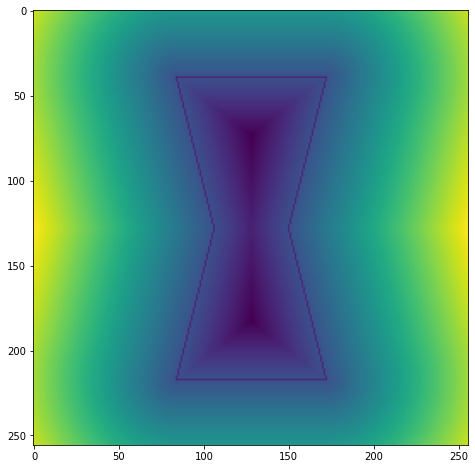

In [ ]:
xx, yy = np.meshgrid(range(img_size), range(img_size))
mat = np.hstack((xx.reshape((-1, 1)), yy.reshape((-1, 1))))

dist_map = dist_oracle.distance_matrix(mat).reshape((img_size, img_size))

plot_signed_distance_field(dist_map, points)
#dans dist_map le premier indice coorespond à l'axe des y (on se déplace selon la hauteur) et le deuxième c laxe des x

Compute single offset polygon...

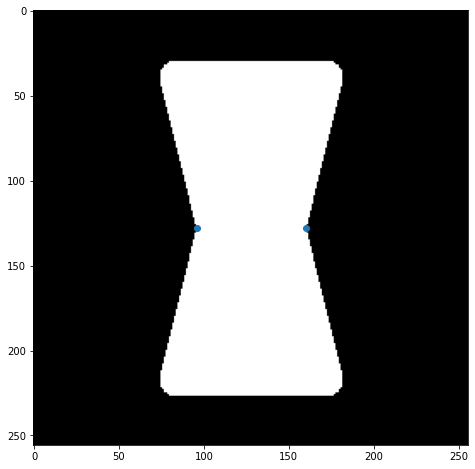

In [ ]:
# points=points[::-1] si les points bleux trouvés sont les points convexes (translatés)

o1 = 10
single_offset = (dist_map < o1).astype(int)
plot_offset(single_offset)

points_concaves=get_points_concave_on_first_offset(points,find_concave_point(points),o1)
plt.scatter(points_concaves[:, 0], points_concaves[:, 1])

In [ ]:
o2=-5
choix = { 1 : bissection_rec_lineaire , 2 : bissection_rec , 3 : newton }
methode=choix[3]

# Start the stopwatch / counter  
t1_start = process_time() 

with Pool(8) as p:
    values = list(tqdm(p.imap(oracle_double_offset_wrapper, range(len(mat))), total = len(mat)))

# Stop the stopwatch / counter 
t1_stop = process_time()

print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

values = np.array(values).reshape((img_size, img_size))


Elapsed time during the whole program in seconds: 76.500757393


In [ ]:
# with open('double_results_star.npy', 'wb') as f:
#     np.save(f, values)

In [ ]:
# with open('double_results.npy', 'rb') as f:
#     values = np.load(f)

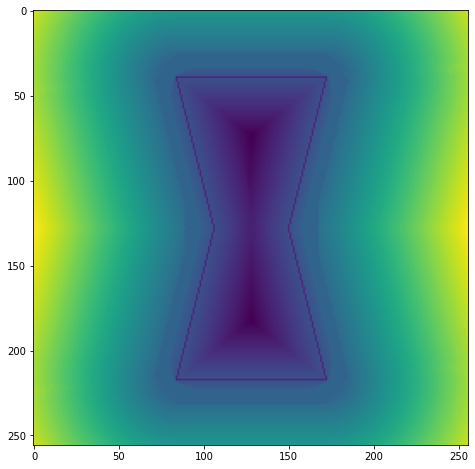

In [ ]:
plot_signed_distance_field(values, points)

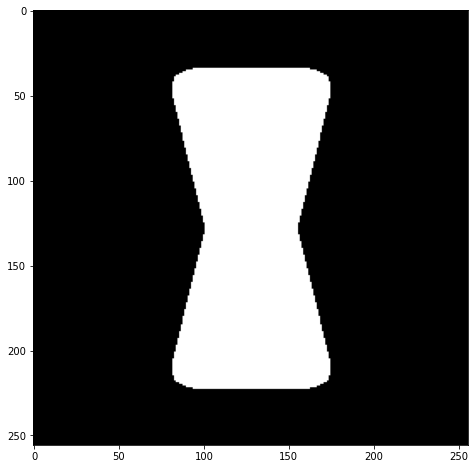

In [ ]:
double_offset = (values < 0).astype(int)
plot_offset(double_offset)